# 02 - Bayesian Player Impact Model
This notebook uses PyMC3 to build a hierarchical Bayesian model that estimates player impact based on World Cup 2018 stats.

In [1]:
!pip install pymc pymc[plotting] arviz --upgrade



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pymc as pm
import arviz as az

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
!pip install --upgrade arviz



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

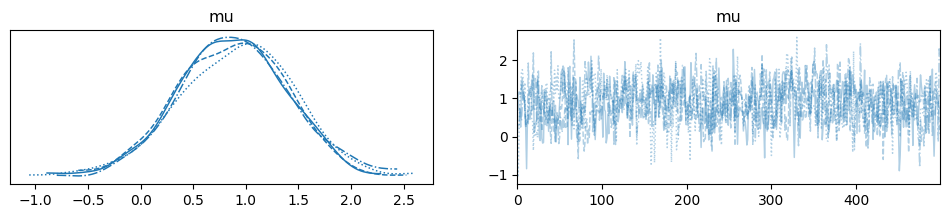

In [4]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=[1.2, 0.9, 1.4])
    idata = pm.sample(500, tune=500, return_inferencedata=True)

az.plot_trace(idata)



In [5]:
# Load feature data
data_path = Path("../data/raw/features_player_match_worldcup_2018.csv")
df = pd.read_csv(data_path)
df = df[df['total_xg'] > 0]  # optional filtering to avoid zero-inflation
df['player_idx'] = df['player.name'].astype('category').cat.codes
num_players = df['player_idx'].nunique()
print(f"Number of player samples: {len(df)}, unique players: {num_players}")

Number of player samples: 900, unique players: 411


In [6]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Player effect (random intercepts)
    tau = pm.HalfNormal('tau', sigma=1)
    player_effect = pm.Normal('player_effect', mu=0, sigma=tau, shape=num_players)
    
    # Coefficients for features
    b_pass_acc = pm.Normal('b_pass_acc', mu=0, sigma=1)
    b_pressure = pm.Normal('b_pressure', mu=0, sigma=1)
    
    mu = (
        alpha 
        + player_effect[df['player_idx'].values] 
        + b_pass_acc * df['pass_accuracy'].values
        + b_pressure * df['num_pressures'].values
    )
    
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df['total_xg'].values)

    # Key line: this returns `idata` directly
    idata = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42, return_inferencedata=True)

# Save the results
az.to_netcdf(idata, "../data/interim/player_model_trace.nc")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, tau, player_effect, b_pass_acc, b_pressure]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6368 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'e:\New folder\bayesball_plus\data\interim\player_model_trace.nc', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [7]:
import os

# Create the directory if it doesn't exist
os.makedirs("../data/interim", exist_ok=True)

# Save the model trace
az.to_netcdf(idata, "../data/interim/player_model_trace.nc")


'../data/interim/player_model_trace.nc'

In [8]:
# Posterior summary
az.summary(idata, var_names=['alpha', 'b_pass_acc', 'b_pressure', 'sigma', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.332,0.062,0.217,0.452,0.001,0.001,2363.0,2642.0,1.00
b_pass_acc,-0.148,0.075,-0.282,0.003,0.002,0.001,2369.0,2876.0,1.00
b_pressure,-0.000,0.001,-0.002,0.002,0.000,0.000,5097.0,3213.0,1.00
sigma,0.278,0.008,0.263,0.292,0.000,0.000,1395.0,2069.0,1.00
tau,0.106,0.014,0.081,0.133,0.001,0.000,232.0,482.0,1.02


In [9]:
# Player effects (top 10 most positive impact)
player_means = idata.posterior['player_effect'].mean(dim=['chain', 'draw']).values
player_names = df[['player_idx', 'player.name']].drop_duplicates().set_index('player_idx')
top_players = pd.DataFrame({
    'player': player_names.loc[range(num_players), 'player.name'].values,
    'impact_score': player_means
}).sort_values(by='impact_score', ascending=False).head(10)
top_players

,player,impact_score
136,Harry Kane,0.268236
284,Neymar da Silva Santos Junior,0.263049
263,Michy Batshuayi Tunga,0.241083
224,Luka Modrić,0.199230
72,Cristiano Ronaldo dos Santos Aveiro,0.170532
13,Aleksandar Mitrović,0.157238
93,Eden Hazard,0.154596
123,Gerard Piqué Bernabéu,0.144198
267,Mile Jedinak,0.143672
35,Antoine Griezmann,0.140391
